In [1]:
"""
This file takes the data extracted using "arxiv-metadata-extraction.ipynb"
and does a bit of post analysis, then plots, and saves figures.
"""

import numpy as np
import pandas as pd
import math
import itertools

import gc
import os
import json
from collections import Counter, defaultdict
from tqdm.notebook import tqdm
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import plotly.graph_objs as go
import kaleido

import plotly.express as px
import re
year_pattern = r'([1-2][0-9]{3})'

from pathlib import Path
root = Path(".")
plots_dir = root / "plots"

from basic_utils import *

## Reload data 

In [2]:
# Load the dictionary from the JSON file, as a dictionary of numpy arrays
with open('author_counts.json', 'r') as f:
    author_counts = json.load(f)
    convert_dict_of_lists_to_dict_of_arrays(author_counts)
with open('author_transitions.json', 'r') as f:
    author_transitions = json.load(f)
    convert_dict_of_lists_to_dict_of_arrays(author_transitions)
# Load the labels 
with open('unique_categories.json', 'r') as f:
    unique_categories = json.load(f)
with open('sorted_dates.json', 'r') as f:
    sorted_dates = json.load(f)
    
# Have to convert the date keys back floats (since json saving converts to strings)
author_counts = {float(key): value for key, value in author_counts.items()}
author_transitions = {float(key): value for key, value in author_transitions.items()}

# Redefine the mappings from category names to indices 

def index_to_category(ind):
    return unique_categories[ind]

def category_to_index(cat):
    return unique_categories.index(cat)

# print(unique_categories)

# Process the data

### Choose how to collapse categories
1. First decide which set of names you want to collapse down to which other set of names 
2. Then create the functions which condense the categories for either vector data or matrix data

In [3]:
# Main choice

which_collapse_type = "major_categories"  
# which_collapse_type = "specific_categories"

In [4]:
# Here are a few options. Feel free to adjust

# NOTE: see category_map in basic_utils.py for a full list of possible categories 

def collapse_categories_function_major(cat):
    """
    This is the major categories collapse.
    
    Returns AI fields if category is in the list AI_fields
    Otherwise returns some major category 
    """
    
    # Basic dictionary to condense categories down to prefixes. 
    AI_fields = {
    'cs.AI',
    'cs.NA',
    'cs.LG',
    'cs.CV',
    'cs.SY',
    'cs.CL',
    'cs.RO',
    'stat.ML',
    'eess.AS',
    'eess.IV',
    'eess.SP'
    }

    # dictionary to condense prefixes further 
    prefix_condensation_dict = defaultdict(lambda: 'other')
    prefix_condensation_dict.update({
    'astro-ph' : 'astrophysics',
    'cond-mat' : 'cond. mat. phys.',
    'cs' : 'comp. sci. (non AI)',
    'gr' : 'physics (other)',
    'hep' : 'nuc. high. en. phys.',
    'math' : 'math',
    'nucl' : 'nuc. high. en. phys.',
    'physics' : 'physics (other)',
    'q-bio' : 'physics (other)',
    'quant-ph' : 'physics (other)',
    'stat' : 'stats (non AI)',
    'econ' : 'econ and finance',
    'nlin' : 'econ and finance',
    'q-fin' : 'econ and finance',
    })

    if cat in AI_fields:
        return 'AI related fields'
    else:
        for pattern in prefix_condensation_dict.keys():
            if cat.lower().startswith(pattern.lower()):
                return prefix_condensation_dict[pattern]
    return 'other'


def collapse_categories_function_specific_prefixes(cat, explore_specific_field_prefix_list):
    """
    This one loads a specific prefix but keeps all subfields, and puts the rest in 'other'
    
    Useful for seeing relative strength within subfields
    """
    """
    Useful prefixes:
    astro-ph, cond-mat, cs, hep, math, nlin, nucl, physics, q-bio, q-fin, stat
    """
    
    # If it matches any, return itself, otherwise other
    for explore_specific_field_prefix in explore_specific_field_prefix_list:
        if cat.lower().startswith(explore_specific_field_prefix.lower()):
            return cat
    else:
        return 'other'
    
def collapse_categories_function_none(cat):
    """
    This one keeps all categories. No change 
    """
    return cat


###### Choose your collapse_categories_function here ######

if which_collapse_type == "major_categories":
    collapse_categories_function = collapse_categories_function_major
elif which_collapse_type == "specific_categories":
    # Choose which fields to keep 
    # explore_specific_field_prefix_list = ['q-bio']  
    # explore_specific_field_prefix_list = ['hep','nucl']
    explore_specific_field_prefix_list = ['physics.atom-ph', 'physics.optics', 'quant-ph', 
                                          'cond-mat.quant-gas', 'cond-mat.str-el', 'cond-mat.supr-con']
    collapse_categories_function = lambda cat: collapse_categories_function_specific_prefixes(cat, explore_specific_field_prefix_list)
else:
    which_collapse_type = "all"
    collapse_categories_function = collapse_categories_function_none

In [5]:
# Create the actual functions which do the collapse

def create_collapse_index_mapping(collapse_dict):
    unique_categories = list(sorted(set(collapse_dict.keys())))
    collapsed_unique_categories = list(sorted(set(collapse_dict.values())))
    index_mapping = {}

    for ind, cat in enumerate(unique_categories):
        collapsed_cat = collapse_dict[cat]
        collapsed_ind = collapsed_unique_categories.index(collapsed_cat)
        index_mapping[ind] = collapsed_ind

    return index_mapping, collapsed_unique_categories

def collapse_transition_matrix(transition_count, index_mapping):
    """
    Careful here. Don't count transitions that are within a collapsed class. 
    """
    
    n_collapsed = len(set(index_mapping.values()))
    collapsed_transition_count = np.zeros((n_collapsed, n_collapsed))

    for source_ind, collapsed_source_ind in index_mapping.items():
        for target_ind, collapsed_target_ind in index_mapping.items():
            
            # Only add to matrix if we are transitioning in or out of classes. 
            if collapsed_target_ind != collapsed_source_ind: 
                collapsed_transition_count[collapsed_source_ind, collapsed_target_ind] += transition_count[source_ind, target_ind]

    return collapsed_transition_count

def collapse_vector(vector, index_mapping):
    
    n_collapsed = len(set(index_mapping.values()))
    collapsed_vector = np.zeros(n_collapsed)

    for source_ind, collapsed_source_ind in index_mapping.items():
        collapsed_vector[collapsed_source_ind] += vector[source_ind]

    return collapsed_vector

# Get collapse mapping, and unique_categories after collapse
collapse_dict = {cat : collapse_categories_function(cat) for cat in unique_categories}
collapse_index_mapping, unique_categories_collapsed = create_collapse_index_mapping(collapse_dict)

In [6]:
# Get collapsed datasets with your chosen categories all mapped to the same labels
    # Run this cell to collapse main data to chosen categories.
    # Also get derived quantities, like net transition count between fields, and the rate of switching.

# Main two datasets everything else is derived from
author_counts_collapsed = {date: collapse_vector(author_counts[date], collapse_index_mapping) 
                               for date in sorted_dates}
author_transitions_collapsed = {date: collapse_transition_matrix(author_transitions[date], collapse_index_mapping) 
                               for date in sorted_dates}

######### Net transitions ######### 

author_net_transitions_collapsed = {date: author_transitions_collapsed[date] - author_transitions_collapsed[date].T
                               for date in sorted_dates}
author_net_transitions_vec_collapsed = {date: np.sum(author_net_transitions_collapsed[date], axis=1) for date in sorted_dates}
    # This is transitions away from this field 
    
######### Cumulative transitions ######### 

# Sum transition net between fields over the previous years
author_cumulative_net_transitions_collapsed = {date: np.sum(np.array([author_net_transitions_collapsed[date_past]
                                                                for date_past in sorted_dates
                                                                if date_past <= date
                                                               ]), axis=0)
                                         for date in sorted_dates}

# Sum transition net out of each field over the previous years
author_cumulative_net_transitions_vec_collapsed = {date: np.sum(np.array([author_net_transitions_vec_collapsed[date_past]
                                                                for date_past in sorted_dates
                                                                if date_past <= date
                                                               ]), axis=0)
                                         for date in sorted_dates}

######### Rate of transitions (normalized by source) ######### 

MIN_COUNTS_TO_REPORT_RATE = 20  
    # To avoid dividing by 0 when normalizing to a number of authors in a field,
    # this constant sets the minimum author count we will allow as a denominator
    
author_rate_collapsed = {date: (author_transitions_collapsed[date]
                                    / np.maximum(author_counts_collapsed[date].reshape(-1,1), MIN_COUNTS_TO_REPORT_RATE))    
                               for date in sorted_dates}
author_net_rate_collapsed = {date: (author_net_transitions_collapsed[date]
                                    / np.maximum(author_counts_collapsed[date].reshape(-1,1), MIN_COUNTS_TO_REPORT_RATE))    
                               for date in sorted_dates}

author_net_rate_vec_collapsed = {date: (author_net_transitions_vec_collapsed[date]
                                        / np.maximum(author_counts_collapsed[date], MIN_COUNTS_TO_REPORT_RATE))
                               for date in sorted_dates}

# Display results

In [7]:
# Parameters
START_YEAR_PLOT = 1995
END_YEAR_PLOT = 2023

ignore_other_as_a_plotting_category = False
    # when false, the category 'other' will be treated like any other category
    # when true, this will not plot any authors who are in the category 'other', or transitions to and from there
        # Note they are still included in some of the variables though. All that's changed is the plotting

In [8]:
# Basic setup
save_dir = plots_dir / which_collapse_type

if ignore_other_as_a_plotting_category:
    IGNORE_CATEGORIES_LIST = ['other']
else:
    IGNORE_CATEGORIES_LIST = []

def reverse_dict_for_plotting(data_dict):
    return {k:-v for k, v in data_dict.items()}

def generate_color_map(n_categories):
    colormap = cm.get_cmap('tab10', n_categories)
    return [colormap(i) for i in range(n_categories)]

color_map_fixed = generate_color_map(len(unique_categories_collapsed))


In [9]:
# Plotting functions

def plot_summary_over_fields():
    sorted_dates_plot = [date for date in sorted_dates
                         if (date > START_YEAR_PLOT and date < END_YEAR_PLOT)]

    fig, axes = plt.subplots(1, 2, figsize=(9, 4.5))
    
    #author_counts_collapsed
    author_cumulative_net_transitions_vec_collapsed_into = reverse_dict_for_plotting(author_cumulative_net_transitions_vec_collapsed)

    # First panel: Author total count 
    for target_field, target_label in enumerate(unique_categories_collapsed):
        if target_label not in IGNORE_CATEGORIES_LIST:
            author_counts = np.array([author_counts_collapsed[date][target_field] for date in sorted_dates
                                 if (date > START_YEAR_PLOT and date < END_YEAR_PLOT)])
            axes[0].plot(sorted_dates_plot, author_counts, label=target_label, color=color_map_fixed[target_field])
    axes[0].plot([START_YEAR_PLOT, END_YEAR_PLOT], [0,0], color= 'black', ls='dashed')
    axes[0].set_title('ArXiv Author Numbers Per Year')
    axes[0].set_xlabel('Year')
    axes[0].set_ylabel('Author number in each field')
    axes[0].set_xlim([START_YEAR_PLOT, END_YEAR_PLOT])
    axes[0].legend()
    
    # Second panel: Cumulative inflow
    for target_field, target_label in enumerate(unique_categories_collapsed):
        if target_label not in IGNORE_CATEGORIES_LIST:
            transition_rate = np.array([author_cumulative_net_transitions_vec_collapsed_into[date][target_field] for date in sorted_dates
                             if (date > START_YEAR_PLOT and date < END_YEAR_PLOT)])
            axes[1].plot(sorted_dates_plot, transition_rate, label=target_label, color=color_map_fixed[target_field])
    axes[1].plot([START_YEAR_PLOT, END_YEAR_PLOT], [0,0], color= 'black', ls='dashed')
    axes[1].set_title('Cumulative Transitions Into Field')
    axes[1].set_xlabel('Year')
    axes[1].set_ylabel('Cumulative net transitions\ninto each field')
    axes[1].set_xlim([START_YEAR_PLOT, END_YEAR_PLOT])
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    return fig
    
def plot_summary_for_field(source_field_name):
    source_index = unique_categories_collapsed.index(source_field_name)
    sorted_dates_plot = [date for date in sorted_dates
                         if (date > START_YEAR_PLOT and date < END_YEAR_PLOT)]

    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    # First panel: Author total count and cumulative transitions
    author_counts = np.array([author_counts_collapsed[date][source_index] for date in sorted_dates
                             if (date > START_YEAR_PLOT and date < END_YEAR_PLOT)])
    author_cumulative_net_transitions_vec_collapsed_into = reverse_dict_for_plotting(author_cumulative_net_transitions_vec_collapsed)
    author_cumulative_transitions_into = np.array([author_cumulative_net_transitions_vec_collapsed_into[date][source_index] for date in sorted_dates
                             if (date > START_YEAR_PLOT and date < END_YEAR_PLOT)])
    axes[0].plot(sorted_dates_plot, author_counts, label='Total author count', color='black')
    axes[0].plot(sorted_dates_plot, author_cumulative_transitions_into, label='Cumulative author\ntransitions into field', color='blue')
    axes[0].plot([START_YEAR_PLOT, END_YEAR_PLOT], [0,0], color= 'black', ls='dashed')
    axes[0].set_title('ArXiv Author Numbers Per Year')
    axes[0].set_xlabel('Year')
    axes[0].set_ylabel('Author number in "'+ source_field_name + '"')
    axes[0].set_xlim([START_YEAR_PLOT, END_YEAR_PLOT])
    axes[0].legend()

    # Second panel: Transition counts out of the field
    for target_field, target_label in enumerate(unique_categories_collapsed):
        if target_field != source_index:
            if target_label not in IGNORE_CATEGORIES_LIST:
                author_cumulative_net_transitions_collapsed_into = reverse_dict_for_plotting(author_cumulative_net_transitions_collapsed)
                cum_transition_counts = np.array([author_cumulative_net_transitions_collapsed_into[date][source_index, target_field] for date in sorted_dates
                                 if (date > START_YEAR_PLOT and date < END_YEAR_PLOT)])
                axes[1].plot(sorted_dates_plot, cum_transition_counts, label=target_label, color=color_map_fixed[target_field])
    axes[1].plot([START_YEAR_PLOT, END_YEAR_PLOT], [0,0], color= 'black', ls='dashed')
    axes[1].set_title('Cumulative Transitions From Other Fields')
    axes[1].set_xlabel('Year')
    axes[1].set_ylabel('Total author number transitioned \ninto "' + source_field_name + '" from [...]')
    axes[1].set_xlim([START_YEAR_PLOT, END_YEAR_PLOT])
    axes[1].legend()
    
    # Third panel: Transition counts out of the field
    for target_field, target_label in enumerate(unique_categories_collapsed):
        if target_field != source_index:
            if target_label not in IGNORE_CATEGORIES_LIST:
                author_net_transitions_collapsed_into = reverse_dict_for_plotting(author_net_transitions_collapsed)
                transition_counts = np.array([author_net_transitions_collapsed_into[date][source_index, target_field] for date in sorted_dates
                                 if (date > START_YEAR_PLOT and date < END_YEAR_PLOT)])
                axes[2].plot(sorted_dates_plot, transition_counts, label=target_label, color=color_map_fixed[target_field])
    axes[2].plot([START_YEAR_PLOT, END_YEAR_PLOT], [0,0], color= 'black', ls='dashed')
    axes[2].set_title('Transitions From Other Fields Per Year')
    axes[2].set_xlabel('Year')
    axes[2].set_ylabel('Author number transitioning \ninto "' + source_field_name + '" from [...]')
    axes[2].set_xlim([START_YEAR_PLOT, END_YEAR_PLOT])
    axes[2].legend()

    # Fourth panel: Net rate per year
    for target_field, target_label in enumerate(unique_categories_collapsed):
        if target_field != source_index:
            if target_label not in IGNORE_CATEGORIES_LIST:
                author_net_rate_collapsed_into = reverse_dict_for_plotting(author_net_rate_collapsed)
                transition_rate = np.array([author_net_rate_collapsed_into[date][source_index, target_field] for date in sorted_dates
                                 if (date > START_YEAR_PLOT and date < END_YEAR_PLOT)])
                axes[3].plot(sorted_dates_plot, transition_rate, label=target_label, color=color_map_fixed[target_field])
    axes[3].plot([START_YEAR_PLOT, END_YEAR_PLOT], [0,0], color= 'black', ls='dashed')
    axes[3].set_title('Transition Rate From Other Fields Per Year')
    axes[3].set_xlabel('Year')
    axes[3].set_ylabel('Net rate from other fields\nto "' + source_field_name + '"\n(per person in "' + source_field_name +'")')
    axes[3].set_xlim([START_YEAR_PLOT, END_YEAR_PLOT])
    
    plt.tight_layout()
    plt.show()
    
    return fig

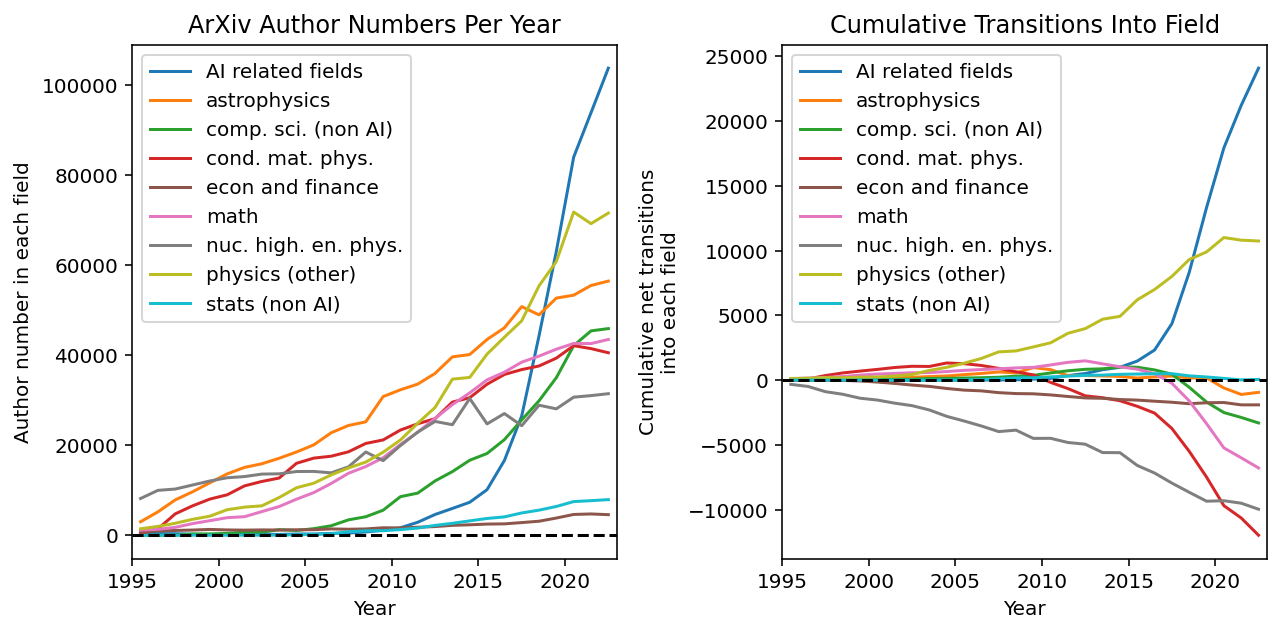

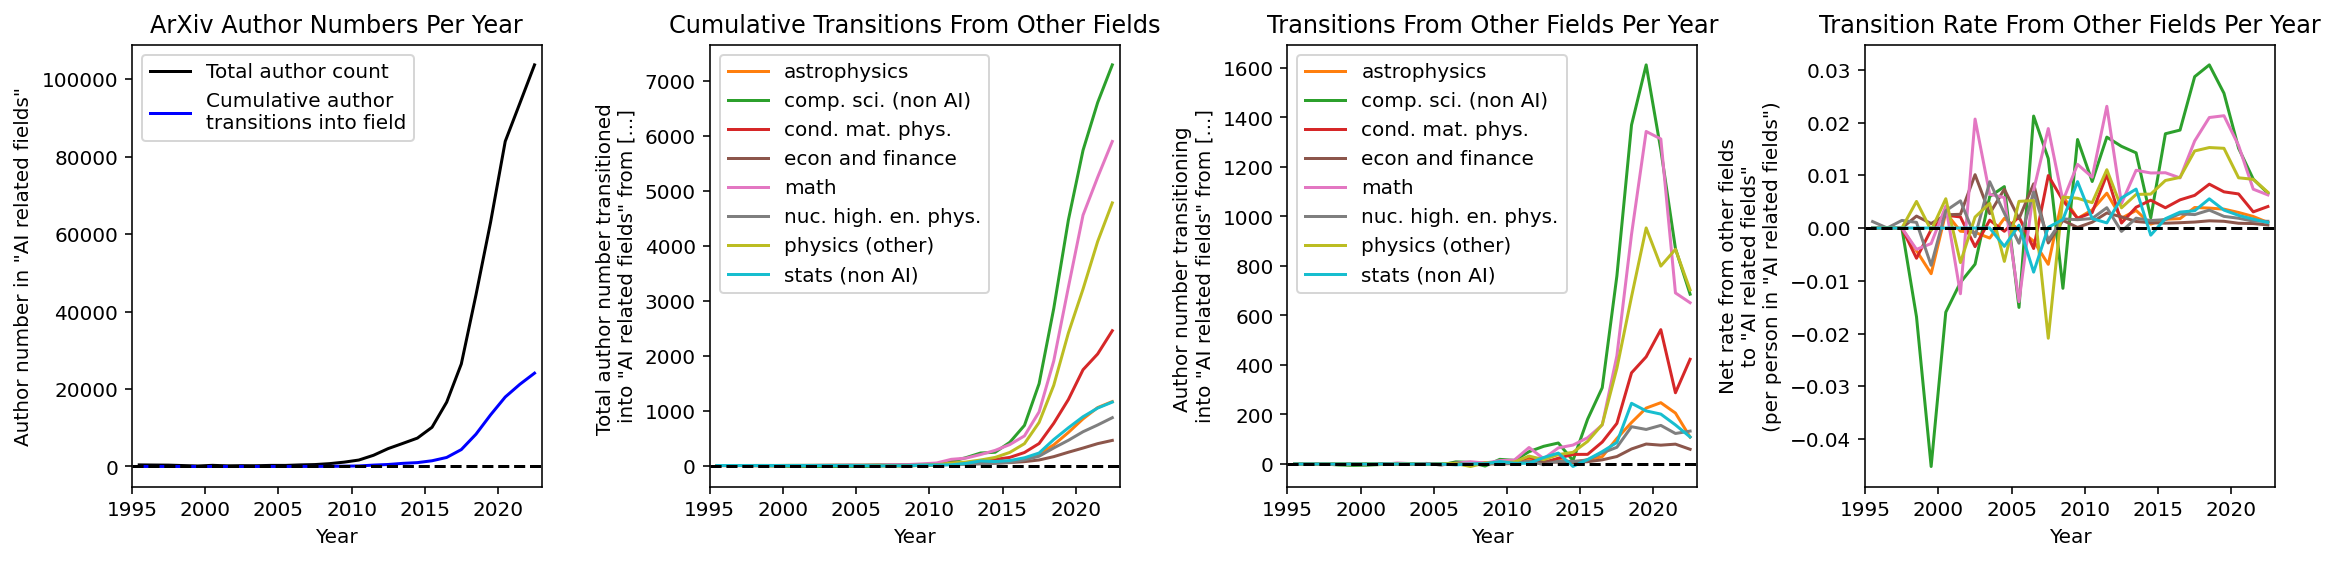

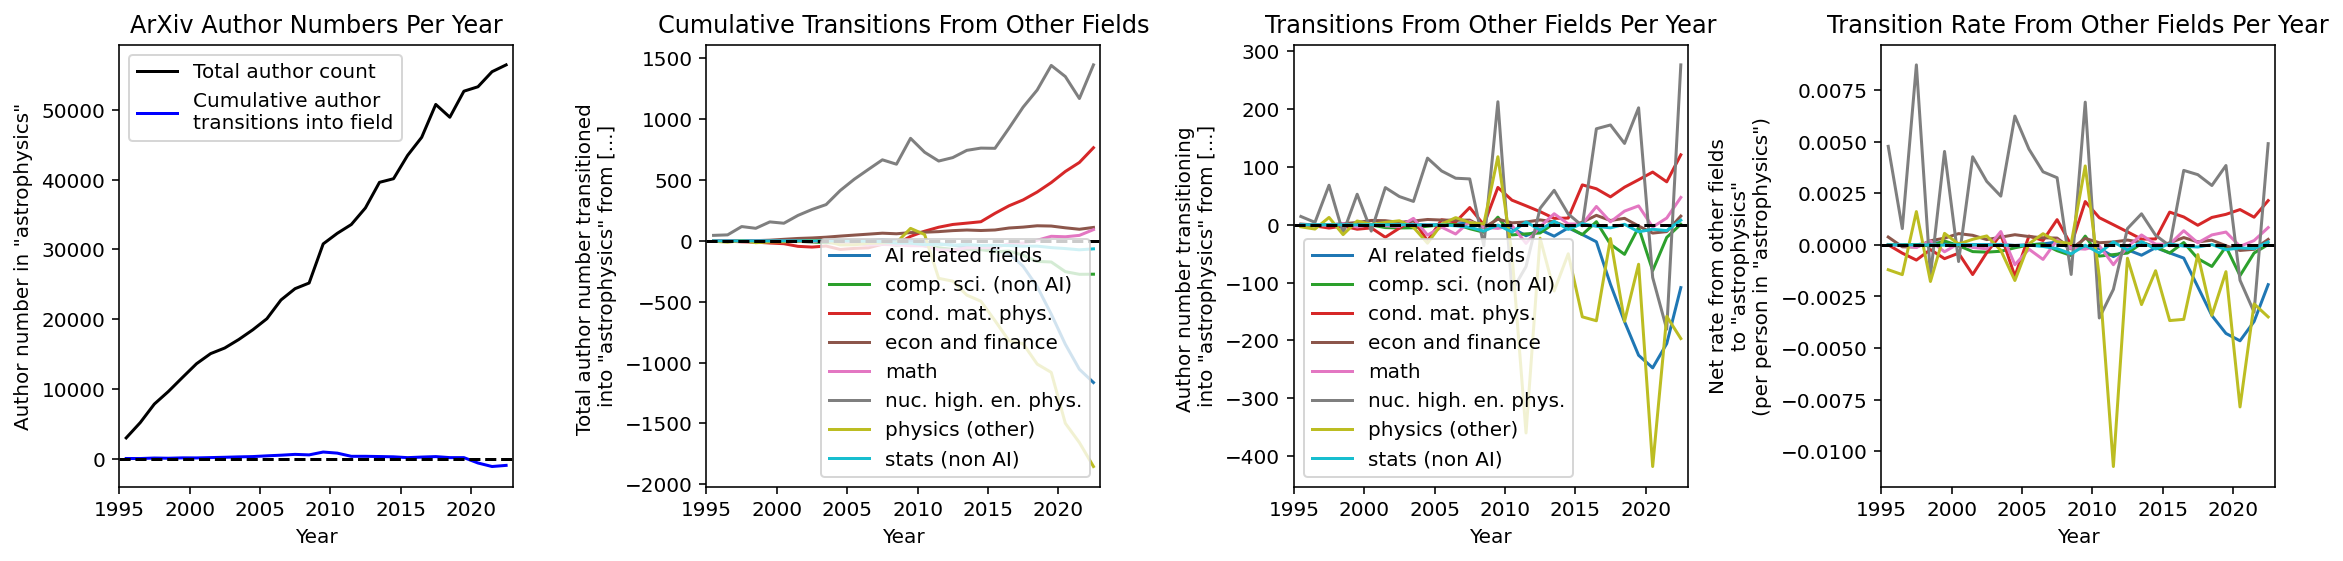

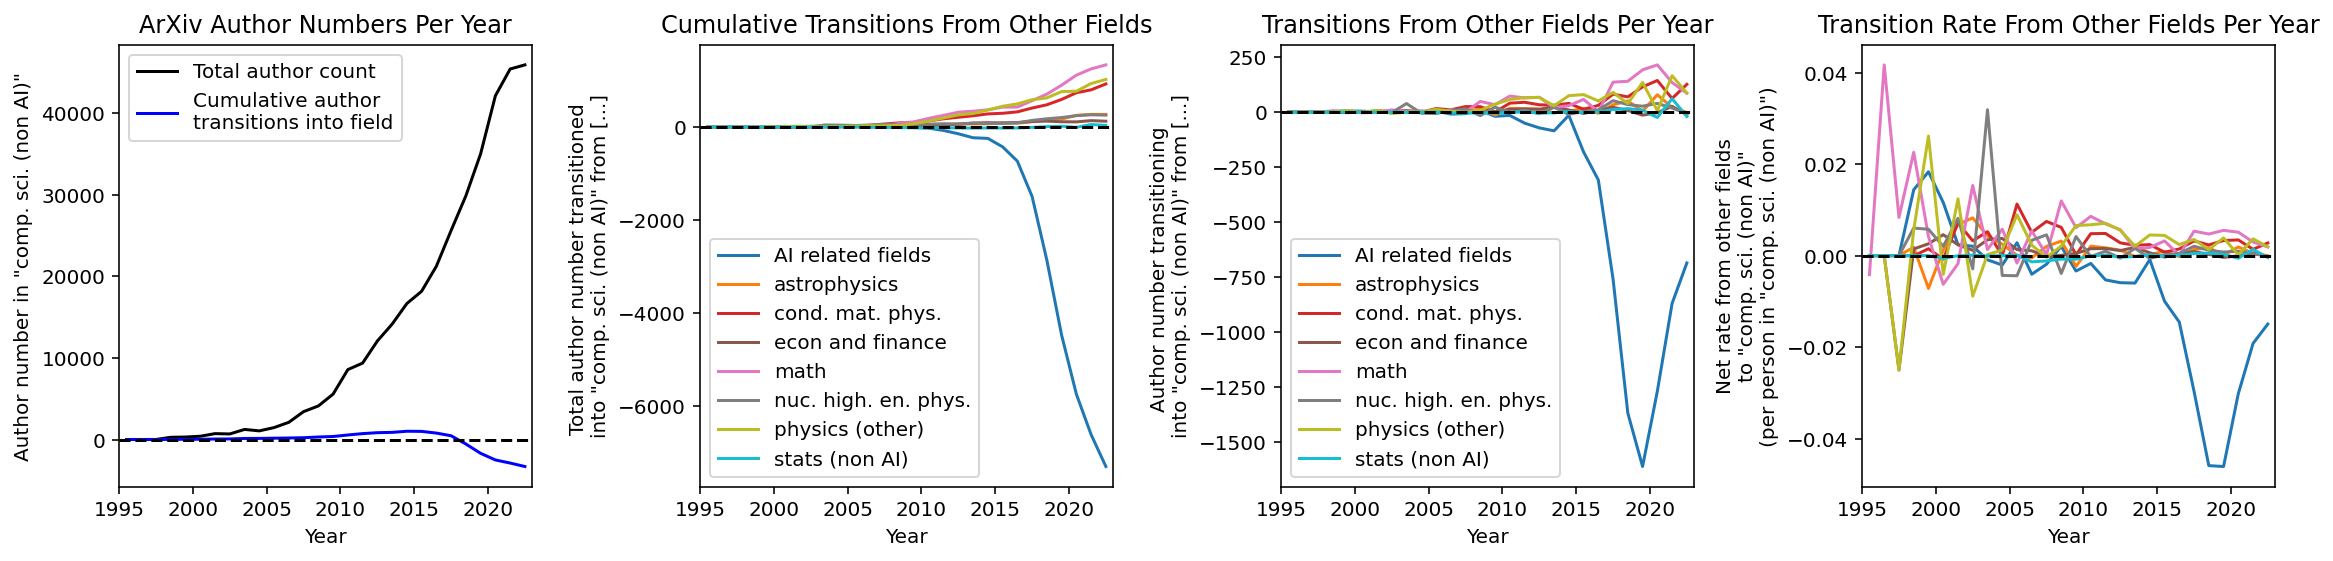

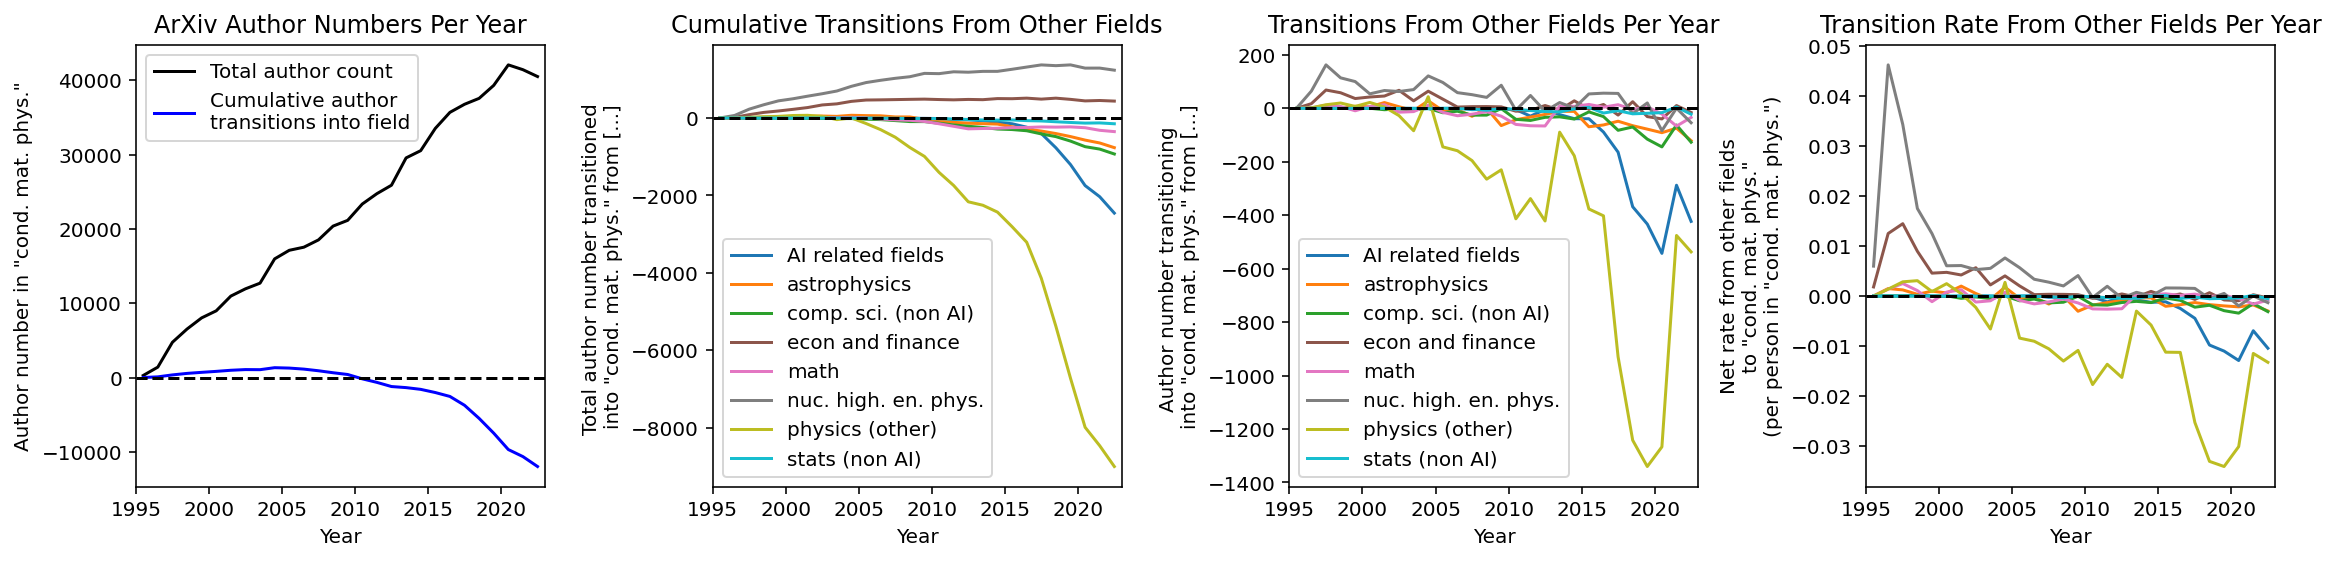

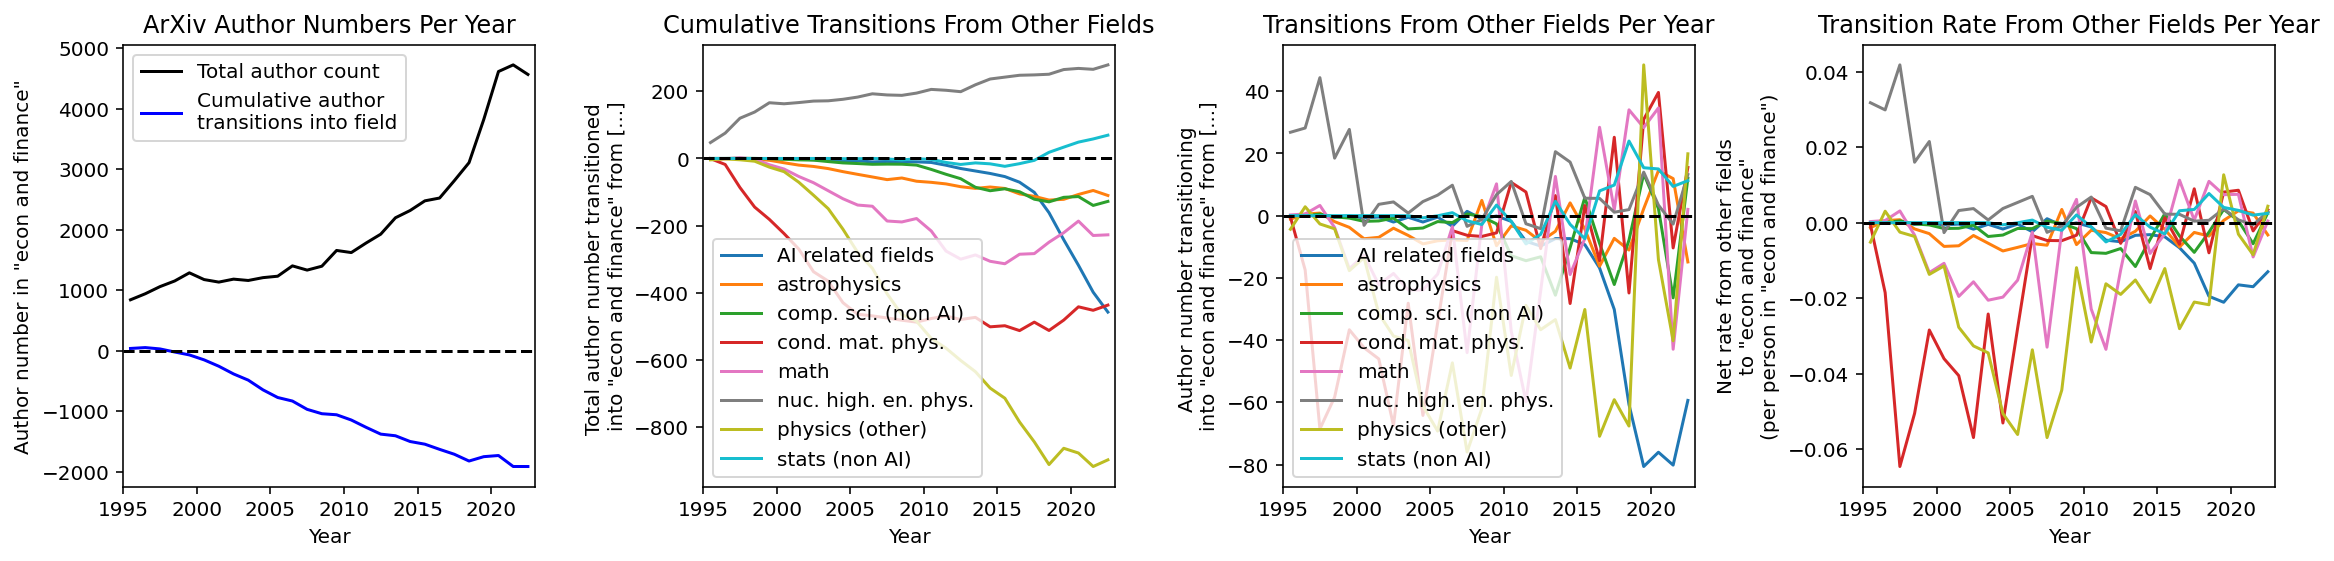

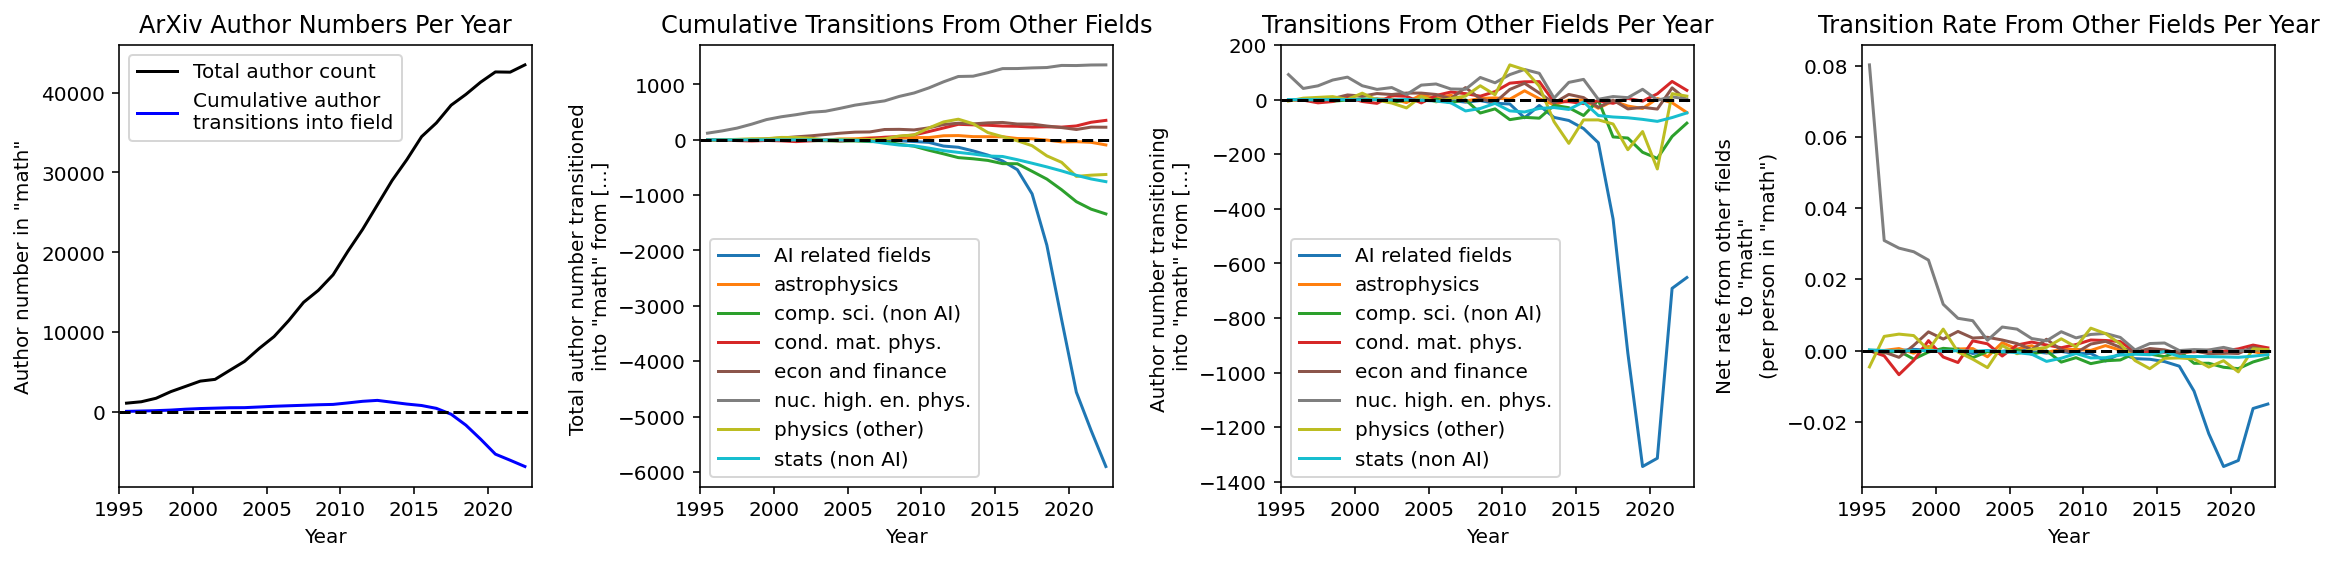

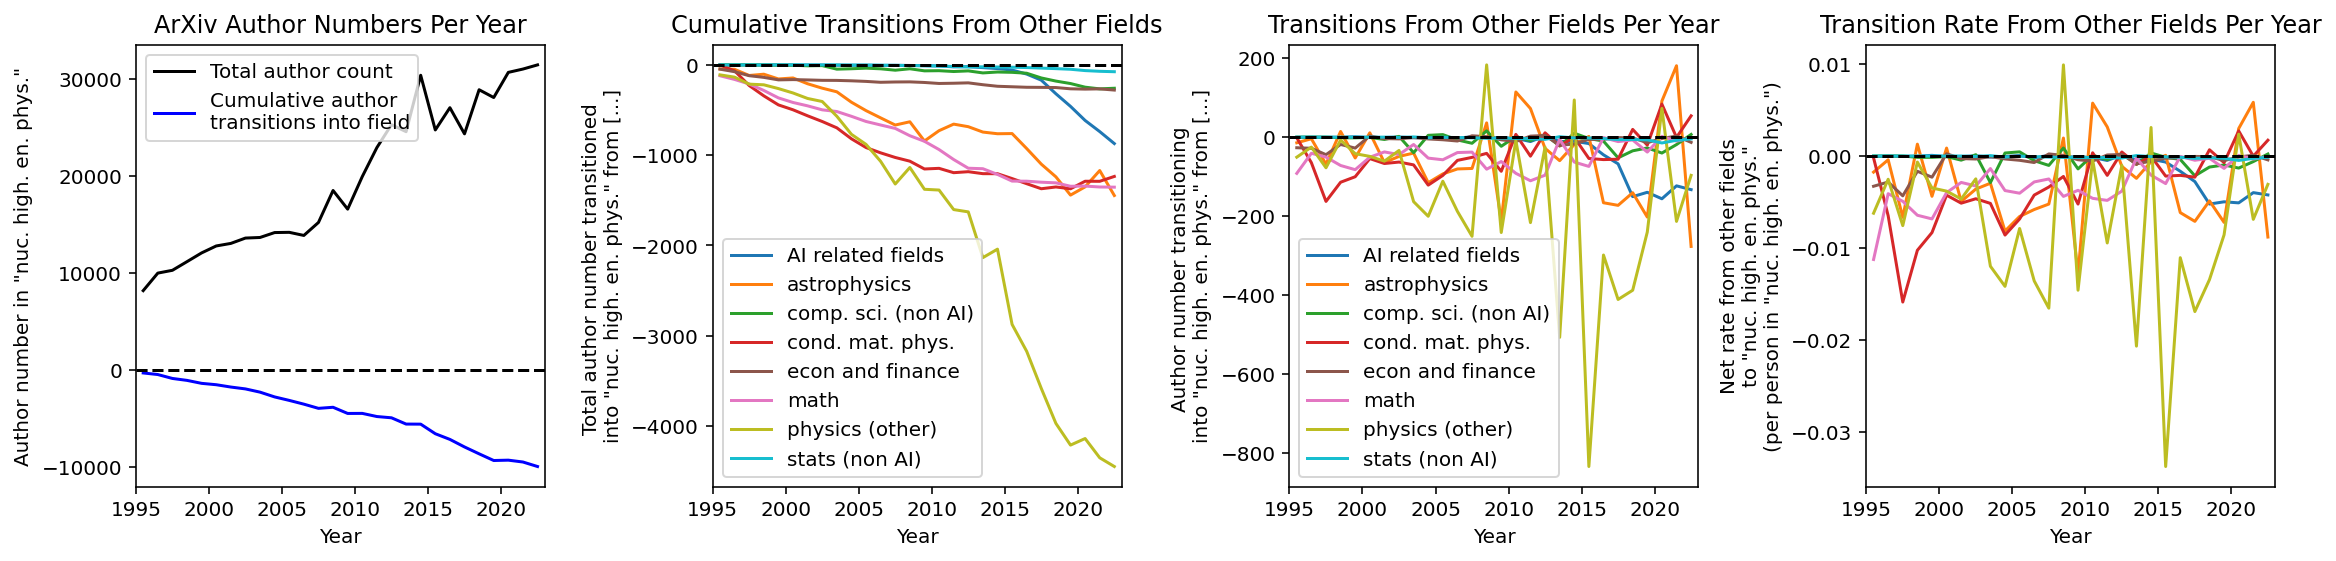

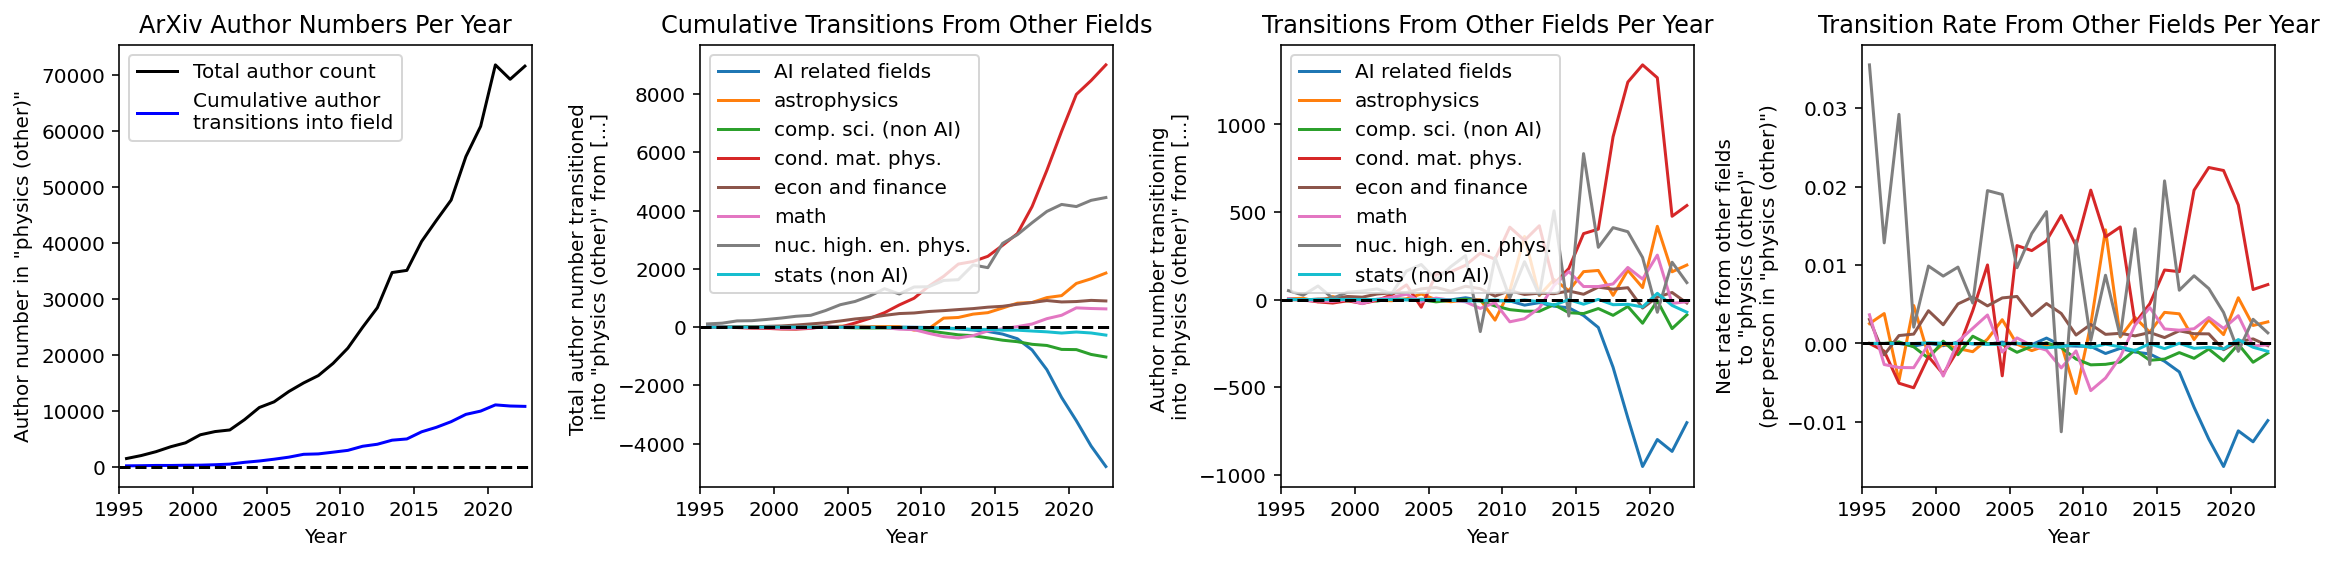

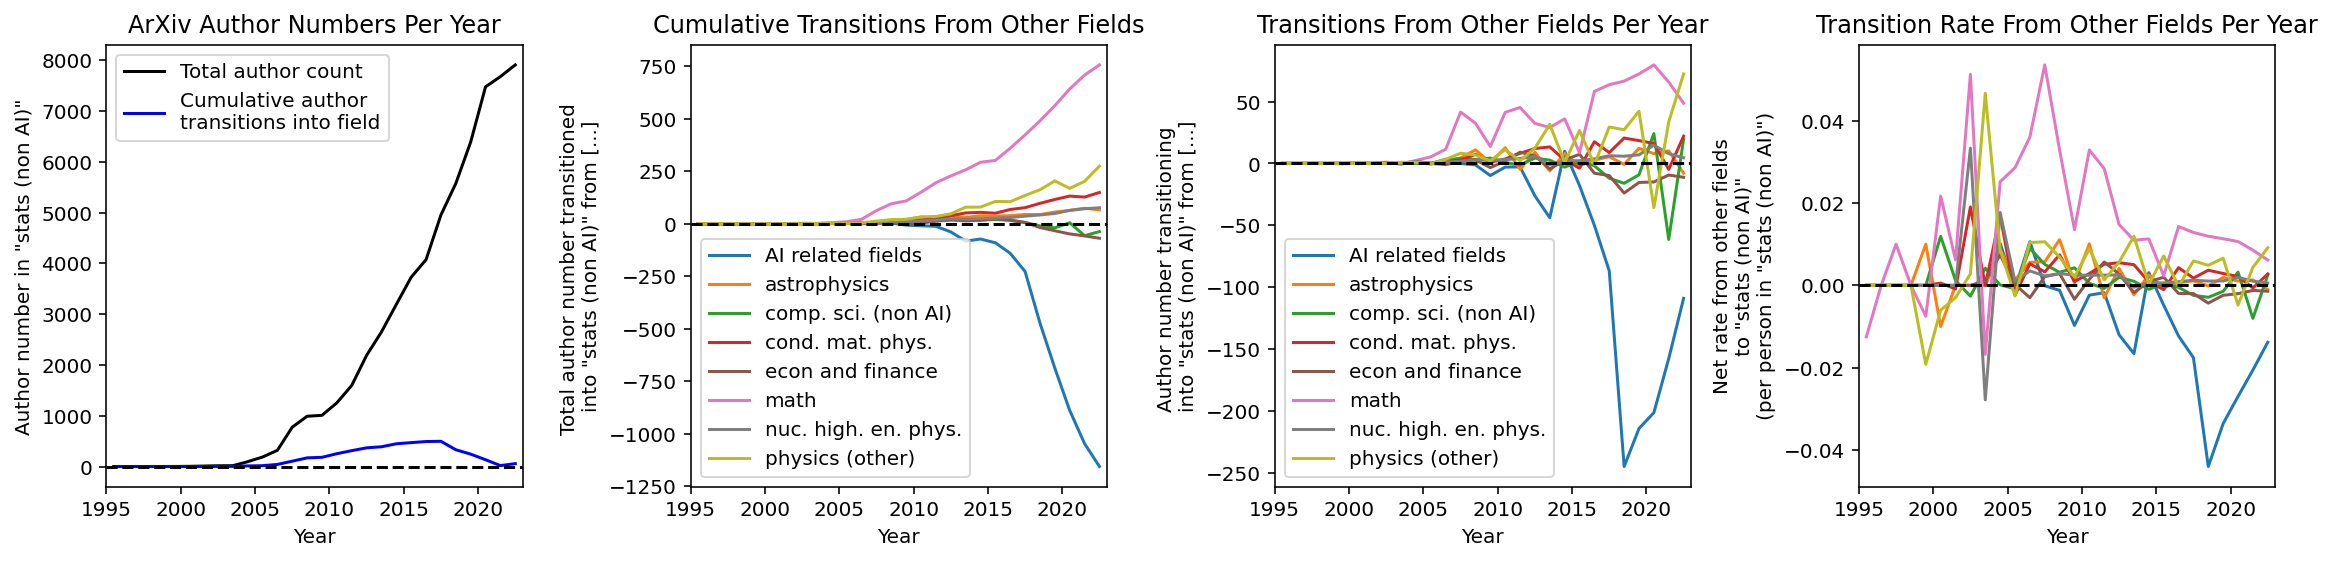

In [10]:
# Generate and save plots

fig = plot_summary_over_fields()
fig.savefig(save_dir / 'Fields_summary.png', dpi=300)

for field_name in unique_categories_collapsed:
    fig = plot_summary_for_field(field_name)
    fig.savefig(save_dir / ('Summary_for_field_'+field_name+'.png'), dpi=300)

## OTHER PLOTTING - Heatmap matrix

In [11]:

def plot_heatmap(matrix, node_labels, plt_range, date_name):
    fig, ax = plt.subplots(figsize = (3.3, 3.3))
    im = ax.imshow(matrix, cmap='bwr', vmin=-plt_range, vmax=plt_range)

    ax.set_xticks(np.arange(matrix.shape[1]))
    ax.set_yticks(np.arange(matrix.shape[0]))

    ax.set_xticklabels(node_labels)
    ax.set_yticklabels(node_labels)

    # Rotate x-axis tick labels
    for tick in ax.get_xticklabels():
        tick.set_rotation(85)
        
    ax.set_xlabel("To node")
    ax.set_ylabel("From this node\n(per size of this node)")
    ax.set_title("Directed Transition\nMatrix in " + date_name)

    fig.colorbar(im, ax=ax)

    plt.show()

for date_ind in [-2 -3*_i for _i in range(0)]:
    plt_range = 0.05
    date_name = str(sorted_dates[date_ind])
    matrix = author_net_rate_collapsed[sorted_dates[date_ind]]
    print(np.sum(np.abs(matrix + matrix.T)))

    plot_heatmap(matrix, unique_categories_collapsed, plt_range, date_name)

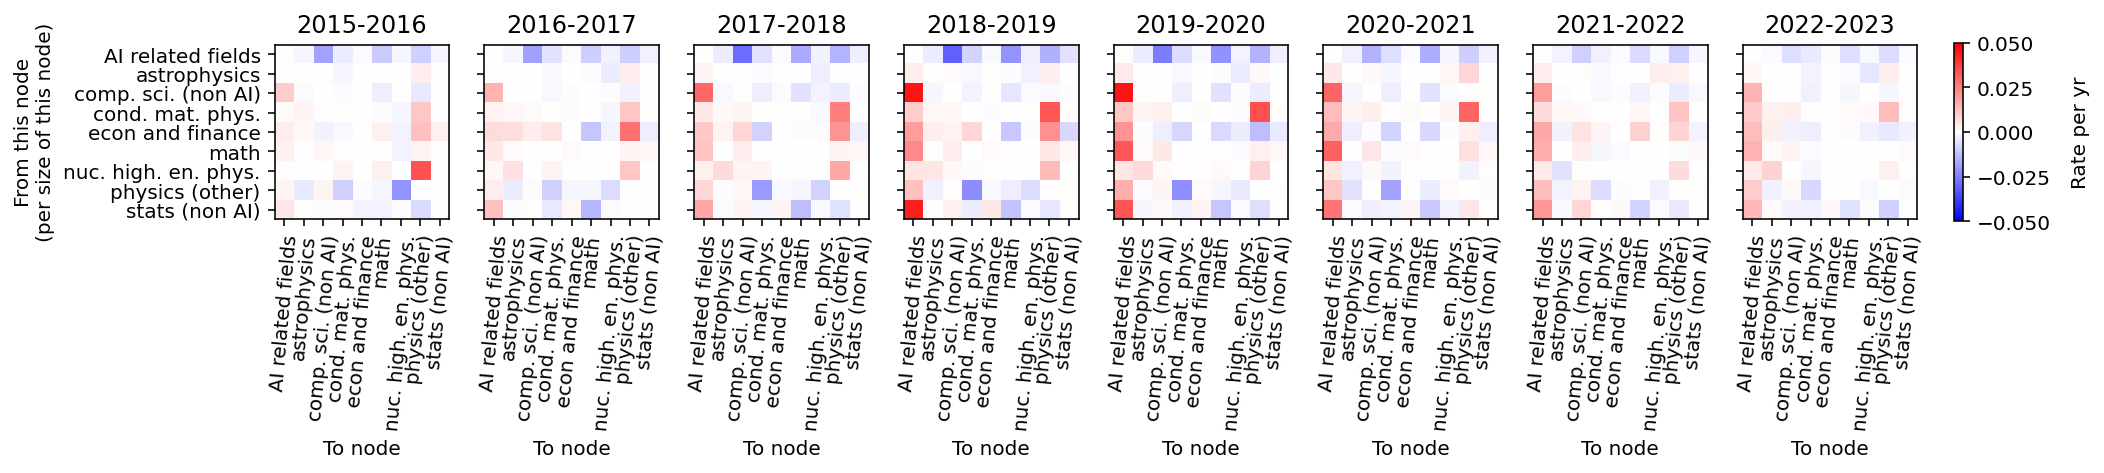

In [12]:

def plot_heatmaps_row(matrix_list, node_labels, plt_range, date_names):
    fig, axes = plt.subplots(1, len(matrix_list), figsize=(2.3 * len(matrix_list), 2.3), sharex=True, sharey=True)

    for i, (matrix, date_name, ax) in enumerate(zip(matrix_list, date_names, axes)):
        im = ax.imshow(matrix, cmap='bwr', vmin=-plt_range, vmax=plt_range)

        ax.set_xticks(np.arange(matrix.shape[1]))
        ax.set_yticks(np.arange(matrix.shape[0]))

        if i == 0:
            ax.set_xticklabels(node_labels)
            ax.set_yticklabels(node_labels)
            ax.set_ylabel("From this node\n(per size of this node)")
        else:
            ax.set_xticklabels(node_labels)
            ax.set_yticklabels(node_labels)

        # Rotate x-axis tick labels
        for tick in ax.get_xticklabels():
            tick.set_rotation(85)
        
        ax.set_xlabel("To node")
        ax.set_title(date_name)

    cbar = fig.colorbar(im, ax=axes, shrink=0.7)
    
    # Get the position of the colorbar
    pos = cbar.ax.get_position()

    # Set a new position for the colorbar
    pos.x0 = pos.x0 - 0.025
    pos.x1 = pos.x1 - 0.025
    cbar.ax.set_position(pos)
    cbar.set_label('Rate per yr', labelpad=10)
    
    plt.show()
    return fig

date_inds = list(reversed([-2 - 1 * _i for _i in range(8)]))
matrix_list = [author_net_rate_collapsed[sorted_dates[date_ind]] for date_ind in date_inds]
date_names = [str(math.floor(sorted_dates[date_ind]))+'-'+str(math.ceil(sorted_dates[date_ind])) for date_ind in date_inds]
plt_range = 0.05

fig = plot_heatmaps_row(matrix_list, unique_categories_collapsed, plt_range, date_names)
fig.savefig(plots_dir / 'Transition_heatmaps.png', dpi=300)
